In [1]:
import graph_tool.all as gt

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rc
import networkx as nx
rc('axes', fc='w')
rc('figure', fc='w')
rc('savefig', fc='w')
rc('axes', axisbelow=True)

### The Data loaded in Graphtool 

In [3]:
# file_path = 'ca-CSphd.mtx'
file_path = 'tech-routers-rf.mtx'
edges = []

with open(file_path, 'r') as f:
    for line in f:
        if line.startswith('%'):  # Skip comment lines starting with '%'
            continue

        # Adjust for 1-based to 0-based indexing
        u, v = map(int, line.split())
        edges.append((u - 1, v - 1))  # Subtract 1 from each node

# Create a graph
g = gt.Graph()

# Add edges to the graph
g.add_edge_list(edges)

# Print the number of vertices and edges to verify
print("Number of vertices:", g.num_vertices())
print("Number of edges:", g.num_edges())


Number of vertices: 2113
Number of edges: 6632


In [4]:
g.is_directed()

True

In [5]:
g.set_directed(False)

In [6]:
g.is_directed()

False

### Same Data loaded in Networkx 

In [8]:
from scipy.io import mmread
# Load the matrix market file (.mtx)
# file_path = 'ca-CSphd.mtx'
file_path = 'tech-routers-rf.mtx'
edges = []
with open(file_path, 'r') as f:
    for line in f:
        if line.startswith('%'):  # Skip comment lines starting with '%'
            continue

        u, v = map(int, line.split())
        edges.append((u, v))

# Create a directed graph
G = nx.DiGraph()

# Add edges to the graph
G.add_edges_from(edges)
G = G.to_undirected()

In [9]:
print(f"Number of Nodes: {G.number_of_nodes()}")
print(f"Number of Edges: {G.number_of_edges()}")

Number of Nodes: 2113
Number of Edges: 6632


1] Community Detection performed on the NetworkX graph

In [10]:
from community import community_louvain

In [11]:
com = community_louvain.best_partition(G)

In [12]:
#To change the output data structure from dictionary to list
def remap_partition(partition):
        """
        Converts and remaps a partition to a list-of-lists structure suitable for modularity calculations.

        This function remaps the input partition (whether it's in dictionary form or a flat list of community labels) 
        to a list-of-lists format, where each list represents a community and contains the nodes in that community. 
        The function also ensures that community labels are contiguous integers starting from 0, which is typically 
        required for modularity-based algorithms.
        """

        # if partition is a dictionary where the keys are nodes and values communities
        if type(partition)==dict:
            unique_comms = np.unique(list(partition.values()))
            comm_mapping = {i:ix for ix,i in enumerate(unique_comms)}
            for i,j in partition.items():
                partition[i] = comm_mapping[j]

            unique_comms = np.unique(list(partition.values()))
            communities = [[] for i in unique_comms]
            for i,j in partition.items():
                communities[j].append(i)
                
            return communities

In [13]:
comm= remap_partition(com)

In [14]:
import networkx.algorithms.community as nx_comm

In [15]:
Q = nx_comm.modularity(G,comm)
print(f"The modularity of best partition of G(nx) is : {Q}")

The modularity of best partition of G(nx) is : 0.6895948914754795


In [18]:
#Number of communities 
communities = len(set(com.values()))
print(f"The number of communities in G(nx) is : {communities}")

The number of communities in G(nx) is : 23


The communities are colored and visualised

In [20]:
from networkx import nx_pydot

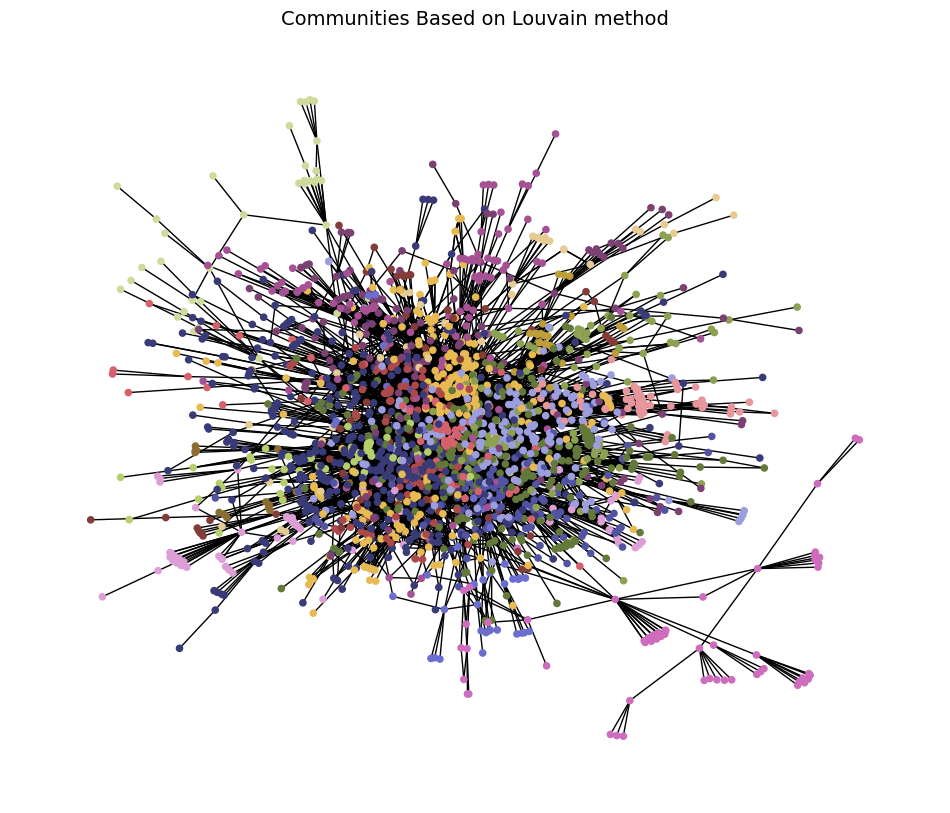

In [21]:

colors_sns = plt.cm.tab20b(np.linspace(0,1,len(np.unique(list(com.values())))))
colors_nodes = [colors_sns[com[node]] for node in G.nodes()]
pos = nx.spring_layout(G, iterations=50) 

fig, ax = plt.subplots(1,1,figsize=(12,10),dpi=100)

nx.draw(G, pos=pos, node_color=colors_nodes, ax=ax, node_size= 20)

plt.title("Communities Based on Louvain method", fontsize=14)
plt.savefig('Communities Based on Louvain method.png', bbox_inches='tight')
plt.show()

Graphtool based community detection

In [22]:
state = gt.minimize_blockmodel_dl(g)

In [28]:
state.draw(output = 'graphtool_community1.png')

<VertexPropertyMap object with value type 'vector<double>', for Graph 0x2b78732e4740, at 0x2b7873849340>

In [24]:
blocks = state.get_blocks()

In [25]:
dictionary_gt = {int(v): int(blocks[v]) for v in g.vertices()}

In [38]:
# print("Partition (node: community):", dictionary_gt)

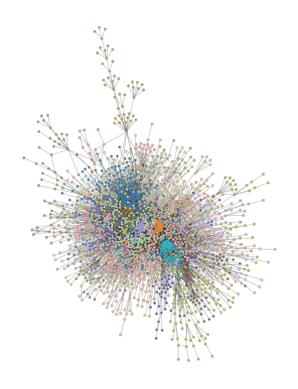

In [26]:
pos = gt.sfdp_layout(g)  # Layout for graph
gt.graph_draw(g, pos, vertex_fill_color=blocks, output_size=(400, 400), output="graph_community.png")

# Display the plot
plt.imshow(plt.imread("graph_community.png"))
plt.axis('off')
plt.show()

### Degree preserving randomization 

In [30]:
gr = gt.random_rewire(g, n_iter=10, model="configuration")

In [36]:
state_r = gt.minimize_blockmodel_dl(g)

In [37]:
blocks_r = state_r.get_blocks()
dictionary_gtr = {int(v): int(blocks_r[v]) for v in g.vertices()}

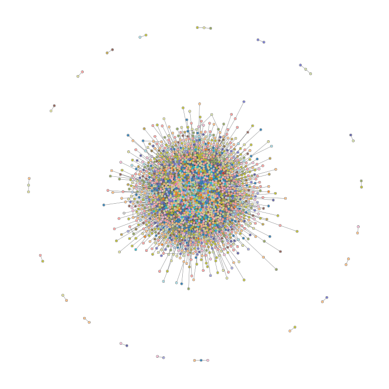

In [38]:
pos = gt.sfdp_layout(g)  # Layout for graph
gt.graph_draw(g, pos, vertex_fill_color=blocks, output_size=(400, 400), output="graph_community_random.png")

# Display the plot
plt.imshow(plt.imread("graph_community_random.png"))
plt.axis('off')
plt.show()

Degree preserving randomization on the Networkx Graph

In [43]:
G_random = G.copy()  # Create a copy of the graph
nx.double_edge_swap(G_random, nswap=2000, max_tries=2500)

In [44]:
com_r = community_louvain.best_partition(G_random)

In [45]:
comm_r= remap_partition(com_r)

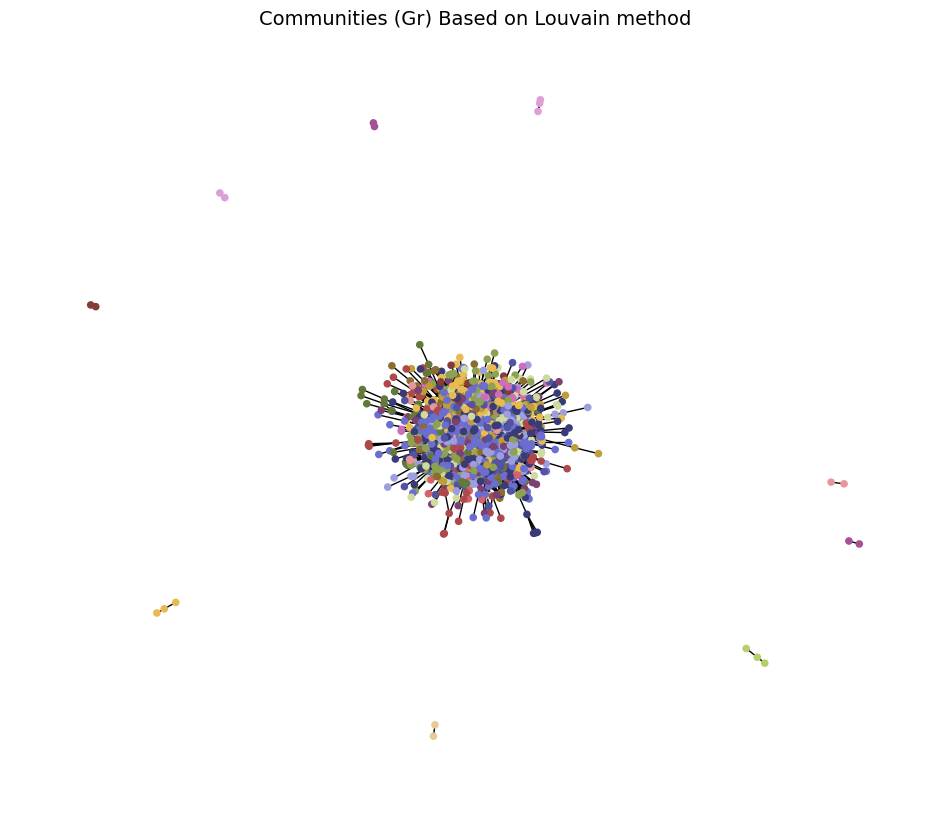

In [46]:
colors_sns = plt.cm.tab20b(np.linspace(0,1,len(np.unique(list(com_r.values())))))
colors_nodes = [colors_sns[com_r[node]] for node in G_random.nodes()]
pos = nx.spring_layout(G_random, iterations=50) 

fig, ax = plt.subplots(1,1,figsize=(12,10),dpi=100)

nx.draw(G_random, pos=pos, node_color=colors_nodes, ax=ax, node_size= 20)

plt.title("Communities (Gr) Based on Louvain method", fontsize=14)
plt.savefig('Communities (Gr) Based on Louvain method.png', bbox_inches='tight')
plt.show()

The Four dictionaries are as follows:

Orignal Network: 
1) Louvian Method = com
2) Graphtool = dictionary_gt

Randomized Network: 
1) Louvian Method = com_r
2) Graphtool = dictionary_gtr